In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from functools import partial
from itertools import product
from contextlib import contextmanager

from xbbg import blp
from xbbg import __version__, const, pipeline
from xbbg.io import logs, files, storage
from xbbg.core import utils, conn, process
from xbbg.core.conn import connect

import datetime
from datetime import timedelta

sns.set(style = "white")


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import scipy.stats as st

from arch import arch_model

import pmdarima as pm

In [45]:
def bdh_intra(tickers = None, start_date = datetime.datetime.now()-timedelta(days = 365), end_date = datetime.datetime.now(), 
              typ='TRADE', freq = 60, **kwargs):
    logger = logs.get_logger(bdh_intra, **kwargs)
    while conn.bbg_session(**kwargs).tryNextEvent(): pass
    request = process.create_request(
        service='//blp/refdata',
        request='IntradayBarRequest',
        settings = [
            ('security', tickers),
            ('eventType', typ),
            ('interval', freq),
            ('startDateTime', start_date),
            ('endDateTime', end_date)
        ],
        **kwargs,
    )
    logger.debug(f'Sending request to Bloomberg ...\n{request}')
    conn.send_request(request=request, **kwargs)

    res = pd.DataFrame(process.rec_events(process.process_bar, **kwargs))
    return res
    

In [46]:
def adfuller_test(df):
    print('Dickey-Fuller Test: ')
    adftest = adfuller(df)
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print(adfoutput)

In [52]:
def arima_garch_signal(pair, vol_days = 30, window_days = 180, log = True, volplot = False, frequency = 60):
    df = bdh_intra(tickers = pair, frequency = 60)
    vector = df[["time", "close"]]
    vector["hour"] = vector["time"].apply(lambda x: x.hour)
    if log == True:
        vector["log"] = vector["close"].apply(lambda x: np.log(x))
    half_day = vector[(vector["hour"] == 0) | (vector["hour"] == 12)]
    half_day.dropna(inplace = True)
    half_day.index = half_day["time"]
    vector.index = vector["time"]
    series_clean = half_day["close"]
    series_clean.index = pd.to_datetime(series_clean.index)
    
    lookbacks = [30, 120, 180]
    
    
    predicts = []
    for lookback in lookbacks:
        
        data_trimmed = series_clean.tail(lookback)
        sm_arima = ARIMA(data_trimmed, order = [2,1,2])
        sm_arima_fit = sm_arima.fit()

        residuals = sm_arima_fit.resid
        
        print(sm_arima_fit.summary())

        garch = arch_model(y = data_trimmed, mean = "AR", vol = "GARCH")
        
        if volplot == True:
            garch_fit = garch.fit()
            garch_fit.plot()
        
        #plt.figure(figsize = (18,18))
        #sns.lineplot(x = data_trimmed.index[-10:], y = data_trimmed.values[-10:])
        #sns.lineplot(x = actual_returns.index, y = actual_returns.values)

        forecast = sm_arima_fit.forecast(steps = 6)
        predicts.append(forecast.values)
        #plt.figure(figsize = (18,18))
        #plt.plot(p_val)

        #future_predicts = sm_arima_fit.forecast(steps = 1)
        #print(future_predicts)
        #print(series_clean[-1])
        #next_return = np.log(future_predicts/(series_clean[-1]))
        #print(next_return/stdev)
    print(predicts)
    rng = pd.date_range(start = series_clean.index[-1], periods = 7, freq = "12H", inclusive = "right")
    plt.figure(figsize = (12,12))
    sns.lineplot(x = series_clean.index[-10:], y = data_trimmed.values[-10:])
    sns.lineplot(x = rng, y = predicts[0])
    sns.lineplot(x = rng, y = predicts[1])
    sns.lineplot(x = rng, y = predicts[2])
    print(rng)

C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["hour"] = vector["time"].apply(lambda x: x.hour)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["log"] = vector["close"].apply(lambda x: np.log(x))
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -37.577
Date:                Mon, 15 Aug 2022   AIC                             85.154
Time:                        18:03:20   BIC                             91.990
Sample:                             0   HQIC                            87.295
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4562      0.398      1.145      0.252      -0.325       1.237
ar.L2         -0.9726      0.264     -3.682      0.000      -1.490      -0.455
ma.L1         -0.3323      4.448     -0.075      0.9

C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no ass

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  180
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -175.460
Date:                Mon, 15 Aug 2022   AIC                            360.920
Time:                        18:03:20   BIC                            376.857
Sample:                             0   HQIC                           367.382
                                - 180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3599      0.065      5.504      0.000       0.232       0.488
ar.L2         -0.9463      0.062    -15.266      0.000      -1.068      -0.825
ma.L1         -0.2802      0.089     -3.154      0.0

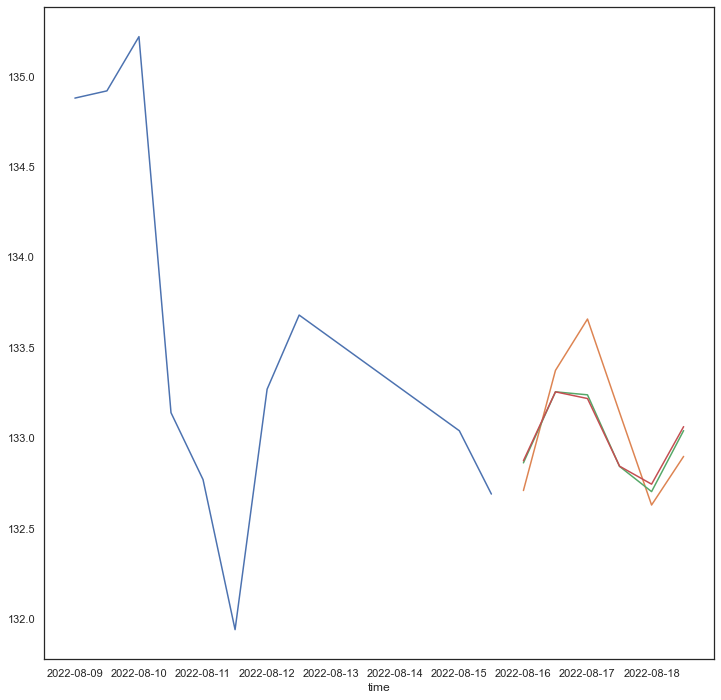

In [53]:
arima_garch_signal("USDJPY CURNCY")

C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["hour"] = vector["time"].apply(lambda x: x.hour)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["log"] = vector["close"].apply(lambda x: np.log(x))
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_8424/3571359185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 116.376
Date:                Mon, 15 Aug 2022   AIC                           -222.753
Time:                        18:03:35   BIC                           -215.916
Sample:                             0   HQIC                          -220.611
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4459      4.421     -0.101      0.920      -9.112       8.220
ar.L2         -0.0453      2.457     -0.018      0.985      -4.862       4.771
ma.L1          0.1948      4.357      0.045      0.9

C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


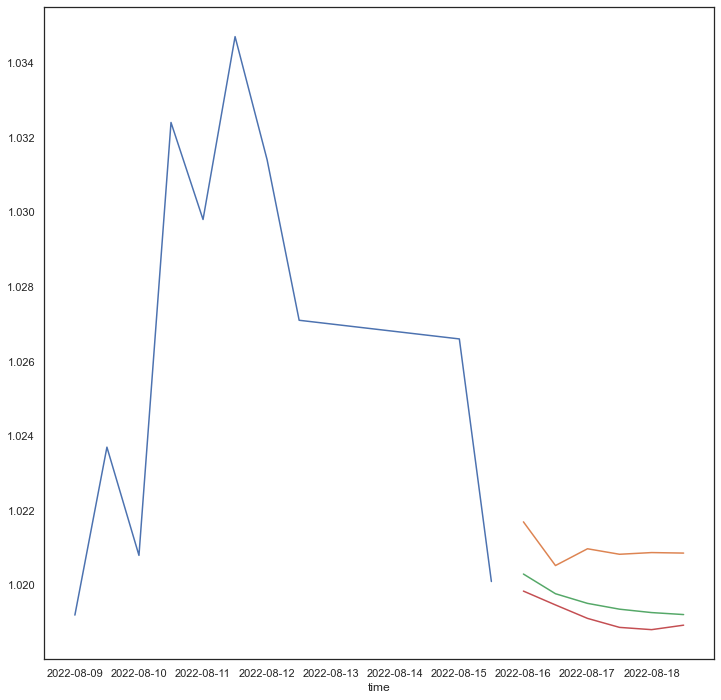

In [54]:
arima_garch_signal("EURUSD CURNCY")

Dickey-Fuller Test: 
Test Statistic           -0.193808
p-value                   0.939256
Lags Used                 1.000000
No. of Observations     280.000000
Critical Value (1%)      -3.453922
Critical Value (5%)      -2.871918
Critical Value (10%)     -2.572300
dtype: float64


C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_2260/3238311566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["hour"] = vector["time"].apply(lambda x: x.hour)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_2260/3238311566.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector["log"] = vector["close"].apply(lambda x: np.log(x))
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a

<Figure size 1152x576 with 0 Axes>

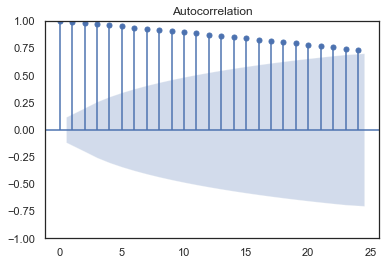

C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


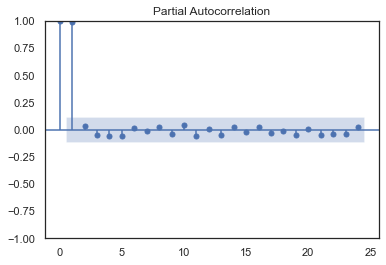

C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No su

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  282
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 267.689
Date:                Fri, 12 Aug 2022   AIC                           -525.379
Time:                        14:46:40   BIC                           -507.187
Sample:                             0   HQIC                          -518.083
                                - 282                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6994      0.234      2.989      0.003       0.241       1.158
ar.L2          0.2506      0.238      1.052      0.293      -0.216       0.717
ma.L1         -0.8311      0.242     -3.436      0.0

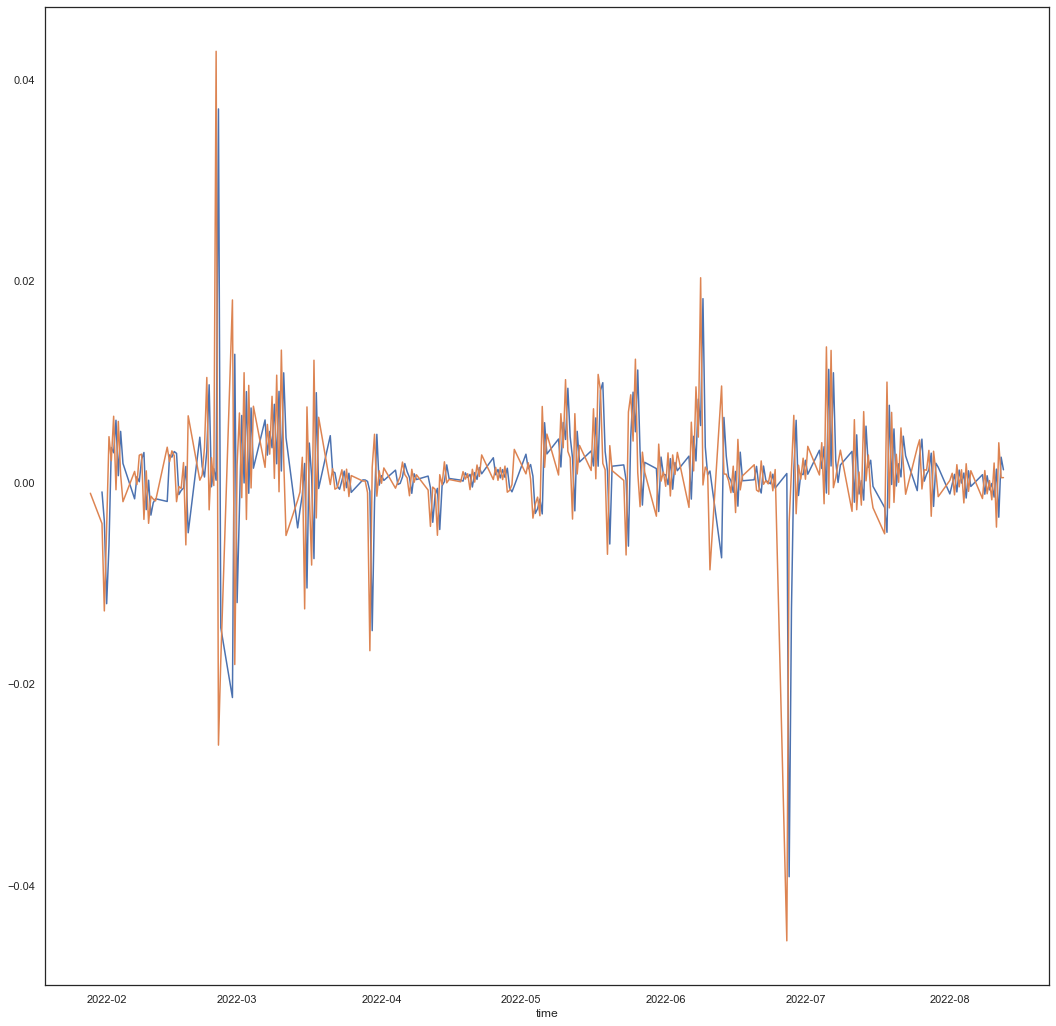

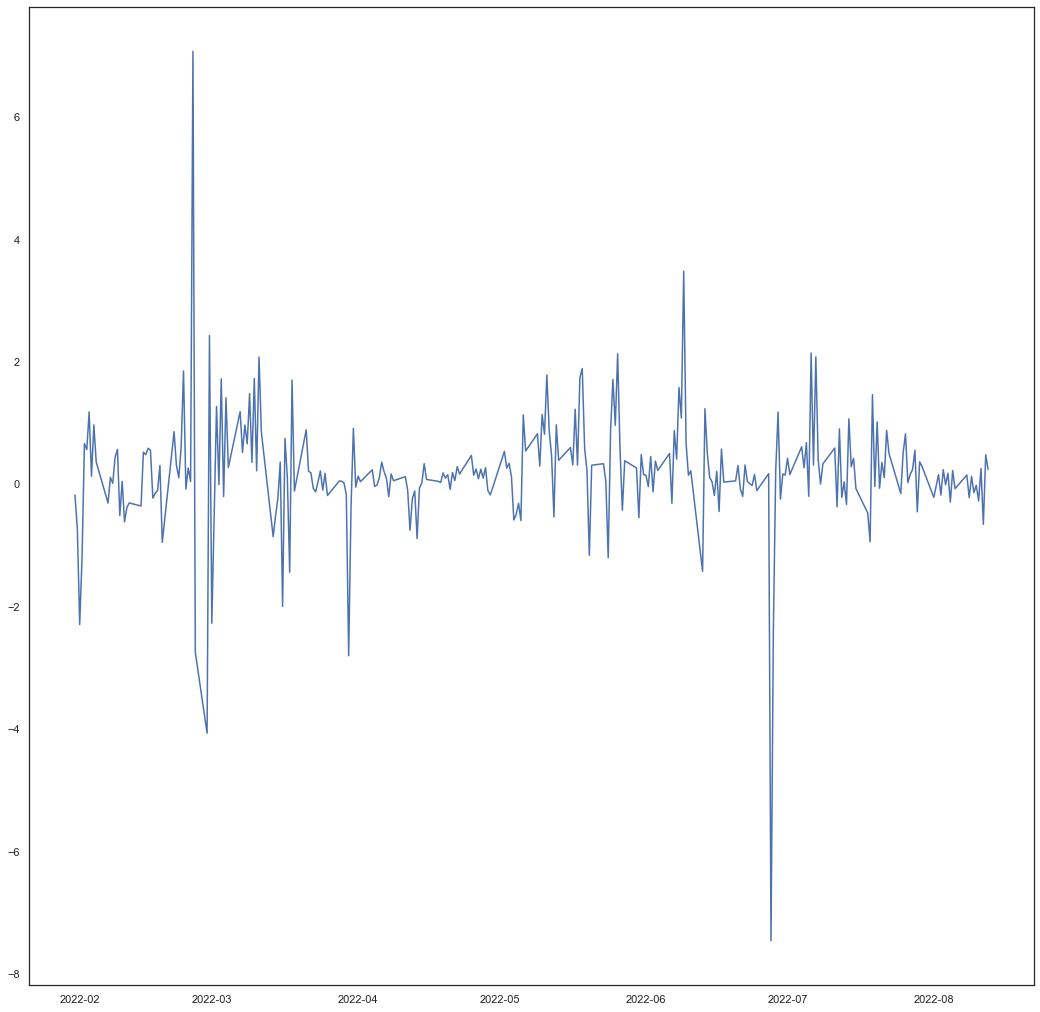

In [525]:
arima_garch_signal("USDTRY CURNCY")

In [44]:
print(bdh_intra('USDJPY CURNCY', freq = 60))

                    time    open    high     low   close  volume  numEvents  \
0    2022-01-31 22:00:00  115.11  115.15  115.10  115.12       0      30887   
1    2022-01-31 23:00:00  115.12  115.14  115.09  115.13       0      35955   
2    2022-02-01 00:00:00  115.13  115.19  115.11  115.15       0      37626   
3    2022-02-01 01:00:00  115.16  115.19  115.02  115.05       0      37963   
4    2022-02-01 02:00:00  115.05  115.14  115.01  115.06       0      36295   
...                  ...     ...     ...     ...     ...     ...        ...   
3421 2022-08-15 13:00:00  132.69  132.83  132.56  132.75       0      59013   
3422 2022-08-15 14:00:00  132.75  133.09  132.70  132.99       0      54438   
3423 2022-08-15 15:00:00  132.99  133.19  132.94  133.15       0      45636   
3424 2022-08-15 16:00:00  133.15  133.27  133.11  133.14       0      40646   
3425 2022-08-15 17:00:00  133.14  133.26  133.14  133.22       0      31859   

      value  
0       0.0  
1       0.0  
2       0